# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install seqeval evaluate Dataset --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but y

In [4]:
pip install accelerate -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import json
import matplotlib.pyplot as plt
from datasets import Dataset
import argparse
from itertools import chain
from functools import partial
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
import evaluate
from datasets import Dataset, features
import numpy as np

# Data Loading

In [7]:
# Load the training data from the JSON file containing labeled data
data = json.load(open("/content/drive/Othercomputers/My Laptop/NEU/Classes/Spring_24/Capstone/Phase 2/data_files/train.json"))

# Downsampling of negative examples to balance the dataset
p = []  # List to store positive samples (containing relevant labels)
n = []  # List to store negative samples (potentially misclassified entities)
for d in data:
    if any(np.array(d["labels"]) != "O"):  # Check if any label is not "O" (indicating relevant label)
        p.append(d)
    else:
        n.append(d)
print("Original datapoints:", len(data))

# Load external dataset for additional data points
external = json.load(open("/content/drive/Othercomputers/My Laptop/NEU/Classes/Spring_24/Capstone/Phase 2/data_files/external.json"))
print("External datapoints:", len(external))

# Load additional dataset for more data points
moredata = json.load(open("/content/drive/Othercomputers/My Laptop/NEU/Classes/Spring_24/Capstone/Phase 2/data_files/moredata.json"))
print("Moredata datapoints:", len(moredata))

# Combine the datasets: moredata, external, positive samples (p), and downsampled negative samples (n)
data = moredata + external + p + n[:len(n)//3]
print("Combined:", len(data))

Original datapoints: 6807
External datapoints: 4434
Moredata datapoints: 2000
Combined: 9333


# Label Extraction

In [8]:
# Extract all unique labels from the combined dataset and sort them
all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))

# Map each unique label to a unique integer identifier
label2id = {l: i for i, l in enumerate(all_labels)}

# Reverse mapping: map integer identifiers back to their corresponding labels
id2label = {v: k for k, v in label2id.items()}
print(label2id)
print(id2label)

{'B-EMAIL': 0, 'B-ID_NUM': 1, 'B-NAME_STUDENT': 2, 'B-PHONE_NUM': 3, 'B-STREET_ADDRESS': 4, 'B-URL_PERSONAL': 5, 'B-USERNAME': 6, 'I-ID_NUM': 7, 'I-NAME_STUDENT': 8, 'I-PHONE_NUM': 9, 'I-STREET_ADDRESS': 10, 'I-URL_PERSONAL': 11, 'O': 12}
{0: 'B-EMAIL', 1: 'B-ID_NUM', 2: 'B-NAME_STUDENT', 3: 'B-PHONE_NUM', 4: 'B-STREET_ADDRESS', 5: 'B-URL_PERSONAL', 6: 'B-USERNAME', 7: 'I-ID_NUM', 8: 'I-NAME_STUDENT', 9: 'I-PHONE_NUM', 10: 'I-STREET_ADDRESS', 11: 'I-URL_PERSONAL', 12: 'O'}


# Dataset Creation Using Hugging Face

In [9]:
# Create a dataset from the provided data dictionary
# Create a dataset from the provided data dictionary
ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [str(x["document"]) for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "labels": [x["labels"] for x in data],
})

# Train Test Split

In [10]:
# Split the dataset into training and testing sets
train_dataset, test_dataset = ds.train_test_split(test_size=0.01, seed=42).values()

# Model Config

In [11]:
# Define the path to the pre-trained DeBERTa-v3 model provided by Microsoft
TRAINING_MODEL_PATH = "dslim/distilbert-NER"

# Define the maximum length of input sequences for training
TRAINING_MAX_LENGTH = 512

# Define the directory where the trained model and associated outputs will be saved
OUTPUT_DIR = "output"

In [12]:
tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# **Working of tokenize_train**



*   Tokens: ["Jane", "Doe", "is", "a", "student", "."]
*   Provided Labels: ["B-PER", "I-PER", "O", "O", "O", "O"]
*   Trailing Whitespace: [True, True, True, True, False, False]

  - This input suggests that "Jane Doe" is a person's name (hence the B-PER for "Beginning-Person" and I-PER for "Inside-Person"), and the rest of the tokens are outside any entity (O). The Trailing Whitespace indicates whether each token is followed by a space when reconstructing the full text.

**1. Rebuild Text from Tokens :**
- First, the function rebuilds the original text from the tokens and trailing whitespace information. For each token:

- If trailing_whitespace is True, it adds a space after the token.
It also extends the labels to match the reconstructed text, ensuring that spaces are labeled as O (outside any named entity).
For our example, the reconstructed text would be "Jane Doe is a student.", and the corresponding labels would be adjusted accordingly (though in this simplified example, labels are assigned per token, not per character, so this step is more about understanding the logic).

**2. Tokenization :**
- Given our rebuilt text from step 1: "Jane Doe is a student.", let's assume the tokenizer performs the following actions (hypothetically, for the sake of example):

- It splits "Jane" and "Doe" as separate tokens, which aligns with our original tokenization.
- It keeps "is", "a", and "student" as separate tokens.
- It recognizes "." as a punctuation token.
- It adds special tokens [CLS] at the beginning and [SEP] at the end of the sequence for model input.
- The tokenized output might look like this (simplified for explanation):
```json
{
    "input_ids": [101, 1234, 5678, 234, 345, 6789, 102],  # Hypothetical token IDs for [CLS], Jane, Doe, is, a, student, [SEP]
    "attention_mask": [1, 1, 1, 1, 1, 1, 1],  # Attention mask values
    "offset_mapping": [(0, 0), (0, 4), (5, 8), (9, 11), (12, 13), (14, 21), (0, 0)]  # Simplified offset mappings
}
```
- Here, offset_mapping indicates the span of characters in the original text each token corresponds to. [CLS] and [SEP] tokens have a mapping of (0, 0) as they don't correspond to any part of the original text.

**3. Align Labels with Tokenized Input :**
- Next, we align the original labels with the new tokenization. Using the offset_mapping, we determine which label each tokenized piece corresponds to:

- For special tokens like [CLS] and [SEP], which don't map to any part of the original text, we assign them a label of O (which we map to its ID, let's say 0 for this example).
- For each tokenized piece, we look at its offset_mapping to find the corresponding character span in the original text and assign it the label that covers the start of this span.
- Given our original labels for "Jane Doe is a student." were ["B-PER", "I-PER", "O", "O", "O", "O"]:

- [CLS] and [SEP] would receive "O" (outside any entity).
- "Jane" starts at character 0, matching "B-PER".
- "Doe" starts at character 5, matching "I-PER".
- The labels for "is", "a", "student", and "." would be "O", since they are outside any named entity.
- Assuming label2id maps "O" to 0, "B-PER" to 1, and "I-PER" to 2, the aligned labels might look like this:

``` json
"labels": [0, 1, 2, 0, 0, 0, 0]  # Aligned labels for [CLS], Jane, Doe, is, a, student, [SEP]
```

- Combining the tokenized inputs and aligned labels, the output for our example step 3 would be:

```json
{
    "input_ids": [101, 1234, 5678, 234, 345, 6789, 102],
    "attention_mask": [1, 1, 1, 1, 1, 1, 1],
    "offset_mapping": [(0, 0), (0, 4), (5, 8), (9, 11), (12, 13), (14, 21), (0, 0)],
    "labels": [0, 1, 2, 0, 0, 0, 0],  # Aligned labels with ID mappings
    "length": 7  # Length of the tokenized sequence
}
```

# Train Tokenizer

In [13]:
def tokenize_train(example, tokenizer, label2id, max_length):

    # Rebuild text from tokens
    text = []
    labels = []

    for t, l, ws in zip(
        example["tokens"], example["labels"], example["trailing_whitespace"]
    ):
        text.append(t)
        labels.extend([l] * len(t))

        if ws:
            text.append(" ")
            labels.append("O")

    # Actual tokenization
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, max_length=max_length, padding="max_length",truncation=True)

    labels = np.array(labels)

    text = "".join(text)
    token_labels = []

    for start_idx, end_idx in tokenized.offset_mapping:
        # CLS token
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
            continue

        # Case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {**tokenized, "labels": token_labels, "length": length}

# Train Test Mapping

In [14]:
train_mapped = train_dataset.map(tokenize_train, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)
test_mapped = test_dataset.map(tokenize_train, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": TRAINING_MAX_LENGTH}, num_proc=3)

Map (num_proc=3):   0%|          | 0/9239 [00:00<?, ? examples/s]

Map (num_proc=3):   0%|          | 0/94 [00:00<?, ? examples/s]

# Model Building

In [15]:
# Load the pre-trained token classification model with the specified parameters
model = AutoModelForTokenClassification.from_pretrained(
    TRAINING_MODEL_PATH,
    num_labels=len(all_labels),  # Number of labels for token classification
    id2label=id2label,  # Mapping from integer labels to their corresponding labels
    label2id=label2id,  # Mapping from labels to their corresponding integer identifiers
    ignore_mismatched_sizes=True  # Ignore mismatched sizes during training
)
model.to(device)

config.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at dslim/distilbert-NER and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([13]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

## Data Collation

In [16]:
# Initialize the data collator for token classification
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

## Compute Metrics Declartion

In [17]:
from seqeval.metrics import recall_score, precision_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

def compute_metrics(p, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Compute recall, precision, and f1-score
    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)

    # Calculate F1-score with beta = 5
    beta = 5
    f1_score_beta = (1 + beta**2) * recall * precision / (beta**2 * precision + recall)

    # Collect and return results
    results = {
        'recall': recall,
        'precision': precision,
        'f1': f1_score_beta
    }
    return results

## Training Arguments

In [18]:
# Define training arguments
args = TrainingArguments(
    output_dir=OUTPUT_DIR,  # Directory where model checkpoints and logs will be saved
    fp16=False,  # Whether to use 16-bit (mixed) precision training
    learning_rate=2e-5,  # Initial learning rate for training
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=1,
    #per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    #per_device_train_batch_size=4,  # Batch size per GPU/CPU for training
    #gradient_accumulation_steps=2,  # Number of updates steps to accumulate before performing a backward/update pass
    report_to="tensorboard",  # Do not report training progress to any backend (e.g., Weights & Biases)
    evaluation_strategy="no",  # No evaluation during training
    do_eval=False,  # Do not perform evaluation during training
    save_total_limit=1,  # Maximum number of checkpoints to save
    logging_steps=20,  # Log training progress every specified number of steps
    lr_scheduler_type='cosine',  # Type of learning rate scheduler
    metric_for_best_model="f1",  # Metric used to determine the best model during training
    greater_is_better=True,  # Whether a higher value of the chosen metric indicates a better model
    warmup_ratio=0.1,  # Ratio of total training steps used for warmup
    weight_decay=0.01  # Strength of weight decay regularization
)

## Training the Model

- Once you are done with the training run this for reports and run it in an ssh where the output directory is specified in the folder
    - tensorboard --logdir=output_dir

In [19]:
# Initialize the Trainer object for training
trainer = Trainer(
    model=model,  # Pre-trained model to be trained
    args=args,  # Training arguments
    train_dataset=train_mapped,  # Training dataset
    data_collator=collator,  # Data collator for token classification
    tokenizer=tokenizer,  # Tokenizer object
    compute_metrics=partial(compute_metrics, all_labels=all_labels),  # Partial function for computing evaluation metrics
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
20,2.827000
40,1.665200
60,0.408800
80,0.194200
100,0.100100
120,0.073600
140,0.056700
160,0.045500
180,0.042100
200,0.036400


TrainOutput(global_step=1731, training_loss=0.07510012577184014, metrics={'train_runtime': 1192.8527, 'train_samples_per_second': 23.236, 'train_steps_per_second': 1.451, 'total_flos': 3619287968071680.0, 'train_loss': 0.07510012577184014, 'epoch': 3.0})

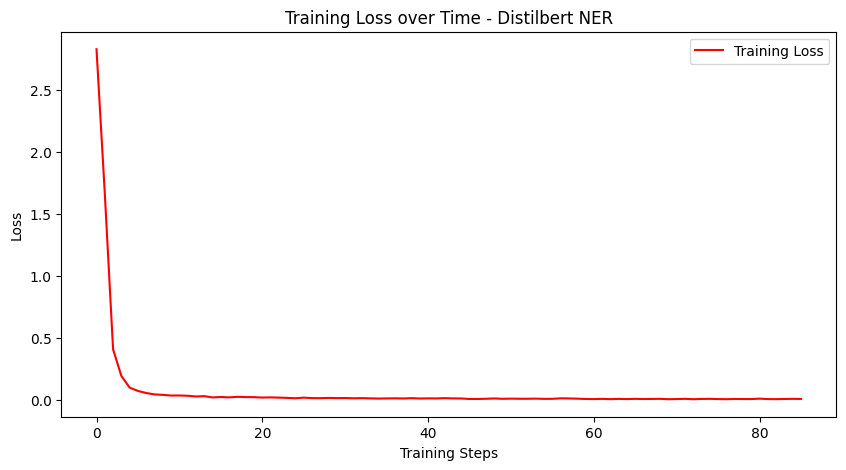

In [20]:
import matplotlib.pyplot as plt

# Extract the loss values from trainer's training stats
losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]

# Create a range of step numbers
steps = range(len(losses))

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss',color = 'red')

# Add title and labels
plt.title('Training Loss over Time - Distilbert NER')
plt.xlabel('Training Steps')
plt.ylabel('Loss')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [21]:
trainer.model.save_pretrained("DistilBERT_NER")
trainer.tokenizer.save_pretrained("DistilBERT_NER_Tokenizer")

('DistilBERT_NER_Tokenizer/tokenizer_config.json',
 'DistilBERT_NER_Tokenizer/special_tokens_map.json',
 'DistilBERT_NER_Tokenizer/vocab.txt',
 'DistilBERT_NER_Tokenizer/added_tokens.json',
 'DistilBERT_NER_Tokenizer/tokenizer.json')

# Generating Predictions

In [24]:
from pathlib import Path
og_labels = test_mapped['labels']
predictions = trainer.predict(test_mapped).predictions
pred_softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis = 2).reshape(predictions.shape[0],predictions.shape[1],1)
model_path='output/checkpoint-1500'
config = json.load(open(Path(model_path) / "config.json"))
id2label = config["id2label"]
preds = predictions.argmax(-1)

preds_without_O = pred_softmax[:,:,:12].argmax(-1)
O_preds = pred_softmax[:,:,12]

threshold = 0.9
preds_final = np.where(O_preds < threshold, preds_without_O , preds)

In [25]:
model_path = 'output/checkpoint-1500'
model = AutoModelForTokenClassification.from_pretrained(model_path)

In [26]:
# Extract relevant features from test_mapped
input_ids = torch.tensor(test_mapped["input_ids"])
# token_type_ids = torch.tensor(test_mapped["token_type_ids"])
attention_mask = torch.tensor(test_mapped["attention_mask"])
og_labels = test_mapped['labels']

# Call the model with the extracted features
outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Now you can access the logits from the outputs
predictions = outputs.logits

# Softmax normalization
pred_softmax = np.exp(predictions.detach().numpy()) / np.sum(np.exp(predictions.detach().numpy()), axis=2).reshape(predictions.shape[0], predictions.shape[1], 1)

# Extracting predictions without 'O' label
preds_without_O = pred_softmax[:, :, :12].argmax(-1)

# Extracting 'O' predictions
O_preds = pred_softmax[:, :, 12]

# Thresholding for 'O' predictions
threshold = 0.9
preds_final = np.where(O_preds < threshold, preds_without_O, predictions.argmax(-1))

# Evaluations

In [27]:
df = pd.DataFrame({
    "og_label": og_labels,
    "pred_label": preds_final.tolist()
})

In [28]:
id2label = {
    0: 'B-EMAIL',
    1: 'B-ID_NUM',
    2: 'B-NAME_STUDENT',
    3: 'B-PHONE_NUM',
    4: 'B-STREET_ADDRESS',
    5: 'B-URL_PERSONAL',
    6: 'B-USERNAME',
    7: 'I-ID_NUM',
    8: 'I-NAME_STUDENT',
    9: 'I-PHONE_NUM',
    10: 'I-STREET_ADDRESS',
    11: 'I-URL_PERSONAL',
    12: 'O'
}

In [29]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Extraction labels excluding O's
og = df['og_label']
pred = df['pred_label']
o = []
p = []
for i in range(len(pred)):
    for j in range(len(pred[i])):
        if og[i][j] != 12:
            p.append(pred[i][j])
            o.append(og[i][j])
o_labels = [id2label[label_id] for label_id in o]
p_labels = [id2label[label_id] for label_id in p]
# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(o,p, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9850
Recall: 0.9834
F1 Score: 0.9842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.metrics import classification_report, precision_recall_fscore_support,confusion_matrix

# Assuming o contains your true labels, and p contains your predicted labels
labels = sorted(list(set(o)))  # Extract the unique labels present in your true labels

# Option 1: Classification Report
report = classification_report(o, p, labels=labels)
print(report)

# Option 2: Precision, Recall, F-score, and Support for each label
precision, recall, fscore, support = precision_recall_fscore_support(o, p, labels=labels)

# # If you want to see metrics for a specific label, e.g., label 1
# for i in range(0,11):
#     label_index = labels.index(i)  # Assuming '1' is a label and you want its index
#     print(f"Label {i} - Precision: {precision[label_index]}, Recall: {recall[label_index]}, F1-Score: {fscore[label_index]}")
#     print("_______________________________________________________________________________________________________________")

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       661
           1       1.00      0.99      1.00       181
           2       1.00      1.00      1.00       428
           3       0.98      0.97      0.97       182
           4       0.99      0.95      0.97       105
           5       0.99      0.99      0.99       450
           6       0.97      0.92      0.95       179
           7       0.98      1.00      0.99        45
           8       1.00      0.99      0.99       164
           9       0.98      0.99      0.98       306
          10       0.99      1.00      0.99       374

   micro avg       0.99      0.98      0.98      3075
   macro avg       0.99      0.98      0.98      3075
weighted avg       0.99      0.98      0.98      3075



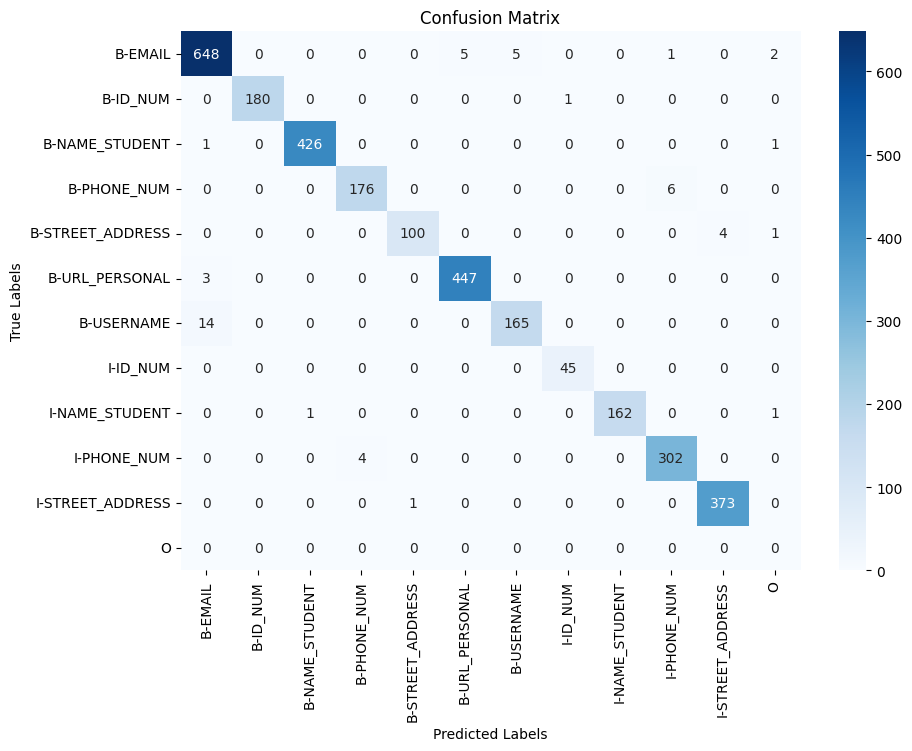

In [31]:
import seaborn as sns
# Assuming 'o' is your list of true labels and 'p' is your list of predicted labels
labels = sorted(list(set(o_labels + p_labels)))  # Get all unique labels from true and predicted labels combined

# Calculate confusion matrix
cm = confusion_matrix(o_labels, p_labels, labels=labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()